In [1]:
import glob
import os
from random import shuffle
import time
import numpy as np
import random
import cv2 as cv
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Activation, Input, Dense, Conv2D, Dropout, Flatten, BatchNormalization
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TerminateOnNaN, TensorBoard
from keras.utils import np_utils

Using TensorFlow backend.


# Define utility and training functions

In [2]:
def get_image_files(root_dir):
    full_paths = [x for x in os.walk(root_dir)]
    imgs = [os.path.join(ds,f) for ds,_,fs in full_paths for f in fs if f]    
    return imgs

def get_dimensions(files):
    min_height, min_width = 10000, 10000
    max_height, max_width = 0, 0
    for f in files:
        img = cv.imread(f)
        h,w = img.shape[:2]
        if h < min_height:
            min_height = h
        if h > max_height:
            max_height = h
        if w < min_width:
            min_width = w
        if w > max_width:
            max_width = w
    return min_height, min_width, max_height, max_width

def make_labels(files):
    # Assume input is a list of complete file paths.
    # Count the number of unique directory names that are immediate parent of the files.
    # Order the directory names alphabetically from a-z, and associate labels accordingly.
    dirs = []
    for f in files:
        dirs.append(f.split('/')[-2])
    unique_dirs = list(set(dirs))
    unique_dirs.sort()
    label_map = {}
    for i,d in enumerate(unique_dirs):
        label_map[d] = i
    return label_map

def make_train_val(files, label_map):
    train = []
    val = []    
    for k in label_map.keys():
        imgs = [f for f in files if k in f]
        num_files = len(imgs)
        train.extend(imgs[:int(.6*num_files)])
        val.extend(imgs[int(.6*num_files):])
    return train, val

def get_batches(files, label_map, batch_size, resize_size, num_color_channels, augment=False, predict=False):
    shuffle(files)
    count = 0
    num_files = len(files)
    num_classes = len(label_map)
    batch_out = np.zeros((batch_size, resize_size[0], resize_size[1], num_color_channels), dtype=np.uint8)
    labels_out = np.zeros((batch_size,num_classes))    
    while True:
        f = files[count%num_files]
        img = cv.imread(f)       
        
        # Resize
        # first resize while keeping aspect ratio
        rows,cols = img.shape[:2]
        rc_ratio = rows/cols
        if resize_size[0] > int(resize_size[1]*rc_ratio):
            img = cv.resize(img, (resize_size[1], int(resize_size[1]*rc_ratio)))
        else:
            img = cv.resize(img, (int(resize_size[0]/rc_ratio), resize_size[0]))
        # then pad to final size
        rows,cols = img.shape[:2]
        res = np.zeros((resize_size[0], resize_size[1], num_color_channels), dtype=np.uint8)
        res[(resize_size[0]-rows)//2:(resize_size[0]-rows)//2+rows,
            (resize_size[1]-cols)//2:(resize_size[1]-cols)//2+cols,:] = img
                
        # Augmentation 
        if augment:            
            rows,cols = res.shape[:2]
            M = cv.getRotationMatrix2D((cols/2,rows/2),np.random.uniform(0.0,360.0,1),1) # random rotation
            res = cv.warpAffine(res,M,(cols,rows))

        if num_color_channels == 1:
            res = cv.cvtColor(res, cv.COLOR_BGR2GRAY)
            res = res[...,None]
        batch_out[count%batch_size,...] = res
        for k in label_map.keys():
            if k in f:
                labels_out[count%batch_size,:] = np_utils.to_categorical(label_map[k],num_classes)
                break
        count += 1
        if count%batch_size == 0:
            if predict:
                yield batch_out.astype(np.float)/255.
            else:
                yield batch_out.astype(np.float)/255., labels_out
            
# Convnet classifier
class classifier():
    def __init__(self,
                 input_shape,
                 n_classes,
                 n_enc_conv_layers=2,
                 n_enc_conv_filters=[32]*2, # individually customizable
                 enc_kernel_size=[(3,2)]*2, # list of integers or tuples
                 n_dense_layers=1,
                 dense_units=[32],
                 dropout=[0.0]*3, # individually customizable
                 strides=[(2,1)]*2,
                 activation='relu',
                 kernel_initializer='glorot_uniform',
                 l1_reg=0.0,
                 lr=0.001
                ):

        if len(n_enc_conv_filters) == 1:
            n_enc_conv_filters = n_enc_conv_filters*n_enc_conv_layers

        if len(enc_kernel_size) == 1:
            enc_kernel_size = enc_kernel_size*n_enc_conv_layers
            
        if len(dense_units) == 1:
            dense_units = dense_units*n_dense_layers

        if len(dropout) == 1:
            dropout = dropout*(n_enc_conv_layers+n_dense_layers)

        if len(strides) == 1:
            strides = strides*n_enc_conv_layers

        self.input_shape=input_shape
        self.n_classes=n_classes
        self.n_enc_conv_layers=n_enc_conv_layers
        self.n_enc_conv_filters=n_enc_conv_filters
        self.enc_kernel_size=enc_kernel_size
        self.n_dense_layers=n_dense_layers
        self.dense_units=dense_units
        self.dropout=dropout
        self.strides=strides
        self.activation=activation
        self.kernel_initializer = kernel_initializer
        self.l1_reg=l1_reg
        self.lr=lr
        self.model = self.get_model()

    def get_model(self):
        I = Input(shape=self.input_shape, name='input')
        X = I
        # Add Conv layers
        for i in range(self.n_enc_conv_layers):
            X = Conv2D(self.n_enc_conv_filters[i], self.enc_kernel_size[i], strides=self.strides[i], padding='same',
                       data_format='channels_last', kernel_initializer=self.kernel_initializer,
                       kernel_regularizer=l1(self.l1_reg), name='conv_{}'.format(i))(X)
            X = Activation(self.activation)(X)
#             X = BatchNormalization()(X)
            X = Dropout(self.dropout[i])(X)
        
        X = Flatten()(X)
        # Add Dense layers
        for i in range(self.n_dense_layers):
            X = Dense(self.dense_units[i], kernel_initializer=self.kernel_initializer,
                      kernel_regularizer=l1(self.l1_reg), name='dense_{}'.format(i))(X)
            X = Activation(self.activation)(X)
#             X = BatchNormalization()(X)
            X = Dropout(self.dropout[i+self.n_enc_conv_layers])(X)
        O = Dense(self.n_classes, activation='softmax', kernel_initializer=self.kernel_initializer,
                  kernel_regularizer=l1(self.l1_reg), name='output')(X)
        
        model = Model(inputs=I, outputs=O)
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.lr), metrics=['accuracy'])
        return model
    
def train(train_files, val_files, label_map, epochs=100, batch_size=8, common_size=(100,100), num_color_channels=3, 
          new_model=True, save_model_name='classification_model_1.hdf5'):
    num_batches_per_epoch = len(train_files)//batch_size
    
    train_batch_generator = get_batches(train_files, label_map, batch_size, common_size, num_color_channels, augment=True)
    val_batch_generator = get_batches(val_files, label_map, batch_size, common_size, num_color_channels)

    checkpt = ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    if new_model: # create a new model
        #### CHANGE THIS SECTION TO CREATE NEW CONVOLUTIONAL ARCHITECTURE ###
        model = classifier([common_size[0], common_size[1], num_color_channels],
                           len(label_map),
                           n_enc_conv_layers=18,#number of convolutional layers
                           n_enc_conv_filters=[64],#number of filters for each conv. layer. Can just put one number to be repeated 
                           enc_kernel_size=[(3,3)],#kernel size for each filter. Can just put one number to be repeated
                           n_dense_layers=2,#number dense layers
                           dense_units=[32],#number of nodes in dense layer. One number gets repeated
                           dropout=[0.0],#proportion of nodes left out of each layer
                           strides=([(1,1)]*2+[(2,2)])*6,#how filter moves across image. Can change stride for each filter. First number is left to right, second is up/down
                           activation='relu',#activation function
                           kernel_initializer='glorot_uniform',#kernel initializer
                           l1_reg=0.0,#l1 norm regularizer
                           lr=0.0001).model #lr = learning rate
    else: # continue to train a previous model
        print('Continuing training from a previous model')
        model = load_model('models/'+save_model_name)

    model.summary()
    model.fit_generator(train_batch_generator, steps_per_epoch=num_batches_per_epoch, epochs=epochs,
                        verbose=1, callbacks=[checkpt, TerminateOnNaN()], 
                        validation_data=val_batch_generator, validation_steps=len(val_files)//batch_size)
    return model

def predict(files, label_map, common_size=(100,100), num_color_channels=3, saved_model_name='classification_model_1.hdf5'):
    model = load_model(saved_model_name)
    num_batches_per_epoch = len(files)    
    predict_batch_generator = get_batches(files, {}, batch_size, common_size, num_color_channels)

    predicts = []
    p = model.predict_generator(predict_batch_generator, steps_per_epoch=num_batches_per_epoch)
    print(p)

# Data Preprocessing

In [3]:
# Get full paths to all classification data
# Data is assumed to reside under the directory "root_dir", and data for each class is assumed to reside in a separate subfolder
root_dir = 'Classification_Images/'
files = get_image_files(root_dir)
print(len(files))
# Get the dimension range of the data for informational purposes
minh,minw,maxh,maxw = get_dimensions(files)
print('Over all images - minimum height: {}, minimum width: {}, maximum height: {}, maximum width:{}'.format(minh,minw,maxh,maxw))
# Assign numerical labels to categories - the number of categories is equal to the number of subfolders
label_map = make_labels(files)
print(label_map)
# Split the data into training and validation
train_files, val_files = make_train_val(files, label_map)
print(len(train_files))
print(len(val_files))

674
Over all images - minimum height: 56, minimum width: 48, maximum height: 256, maximum width:304
{'Ciliate': 0, 'Prorocentrum_micans': 1}
403
271


/home/dtaniguchi/.conda/envs/tensorflow_1.10_python_3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


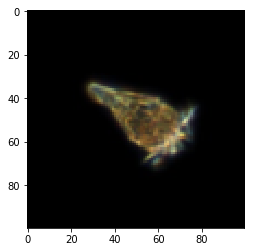

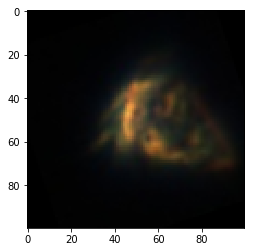

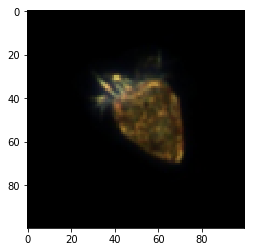

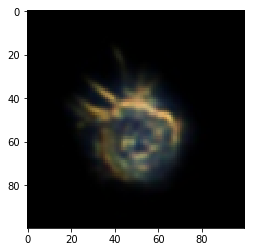

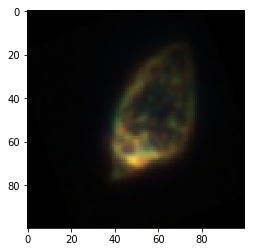

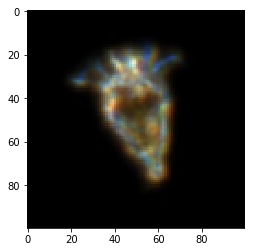

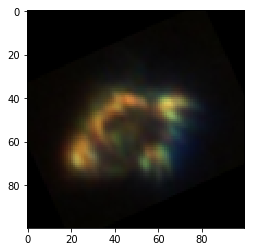

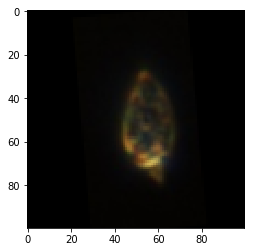

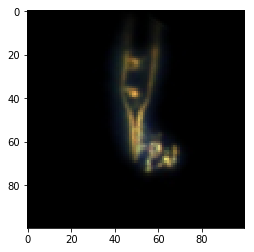

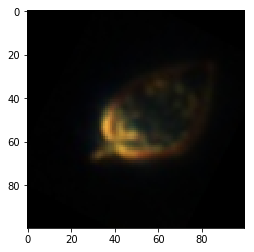

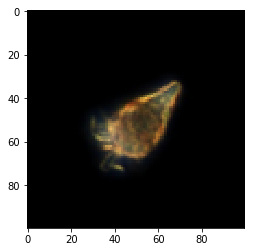

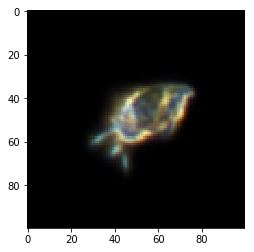

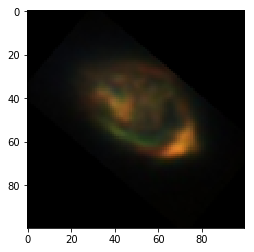

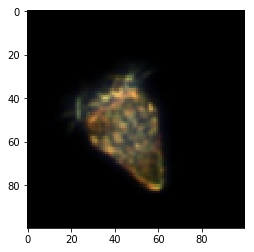

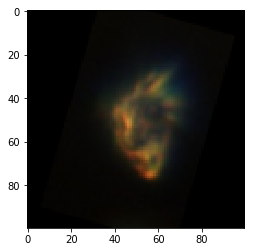

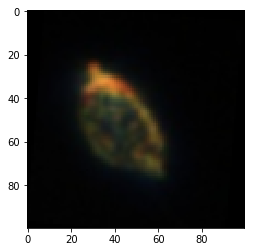

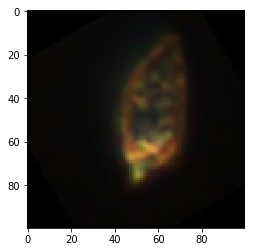

In [ ]:
batch_size = 32
common_size = (100,100)
num_color_channels = 3
train_files = train_files[:len(train_files)//batch_size*batch_size]
g = get_batches(train_files, label_map, batch_size, common_size, num_color_channels, augment=True)
b,l = next(g)
for i in b:
    plt.figure()
    plt.imshow(i[...,::-1])

# Training Classifier

In [ ]:
# Train a classifier
# Note: all images are resized to common_size.  Change as desired. 
# Images smaller than common_size will be enlarged using interpolation.  Images larger will be shrunk using decimation.
batch_size = 32
epochs = 2000
train_files = train_files[:len(train_files)//batch_size*batch_size]
val_files = val_files[:len(val_files)//batch_size*batch_size]
print(len(train_files))
print(len(val_files))
model = train(train_files, val_files, label_map, epochs=epochs, batch_size=batch_size, common_size=(200,200), num_color_channels=3, 
              new_model=True, save_model_name='classification_model_1.hdf5')

# Prediction on New Data